In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
from tqdm import tqdm_notebook as tqdm
import os
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [2]:
reg_data_df = pd.read_csv('../../data/processed/regression_data.csv')

## Nonlinear Control IV Regressions

\begin{align*}
Q &= P \beta_d + f(T) + u_d \\
Q &= P \beta_s + g(W) + u_s \\
P &= (\beta_d - \beta_s)^{-1} \, \left(  g(W) - f(T) + u_s - u_d \right)  \\
E(u_d \, | \, T, W) &= 0 \\
E(u_s \, | \, T, W) &= 0 \\
\end{align*}

where $f(T)$ is some nonlinear function of $T$ and $g(W)$ is some nonlinear function of $W$. 

Let $\alpha = (\beta_d - \beta_s)^{-1}$. Firstly, note that we have:
\begin{align*}
E(P\,|\,T) &= \alpha (E(W) - f(T)) \\
E(P\,|\,W) &= \alpha (g(W) - E(T)) \\
E(P\,|\,T,W) &= \alpha(g(W) - f(T)) 
\end{align*}

Now, differencing $Q$ with its conditional expectation, we have:
\begin{align*}
Q - E(Q \,|\,T) &= (P - E(P\,|\,T))\beta_d + (f(T) - E(f(T) \,|\,T)) + (u_d - E(u_d|T))\\
&= (\alpha(g(W) - E(W)))\beta_d + 0 + u_d 
\end{align*}
Now, note that we also have:
$$E(P\,|\,T,W) - E(P\,|\,T) = \alpha (g(W) - E(W))$$
hence we can regress 
$$(Q - E(Q \,|\,T)) \sim (E(P\,|\,T,W) - E(P\,|\,T)) $$ 
to estimate $\beta_d$

In [3]:
# Data
reg_data_sample_df = reg_data_df.copy()
reg_data_sample_df['1'] = 1
print(len(reg_data_sample_df))

6817


In [10]:
# Additional trimming if desired - should be set to 0 for original results
trim_pct = 0.00
reg_columns = ['ln_load_rel', 'ln_price_rel', 'ln_coal_rel', 'time_diff', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']

for col in reg_columns:
    lower, upper = (reg_data_sample_df[col].quantile(trim_pct/2), reg_data_sample_df[col].quantile(1-trim_pct/2))
    reg_data_sample_df[col] = reg_data_sample_df[col].apply(
        lambda x: x if (lower <= x <= upper) else np.nan)

reg_data_sample_df = reg_data_sample_df[reg_columns].dropna()
len(reg_data_sample_df)

6817

### No controls

In [70]:
w  = np.array(reg_data_sample_df[['ln_coal_rel']])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c'*np.shape(w)[1], 
                             bw=[bw_silverman(w)]).fit(w)

In [71]:
reg_data_sample_df['ce_p_w']  = ce_p_w

In [72]:
fit_1 = smf.ols('ln_load_rel ~ ce_p_w', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     313.8
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           1.08e-68
Time:                        14:24:09   Log-Likelihood:                -1052.7
No. Observations:                6817   AIC:                             2109.
Df Residuals:                    6815   BIC:                             2123.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0054      0.004     -1.210      0.226      -0.014       0.003
ce_p_w        -2.9976      0.169    -17.716      0.000      -3.329      -2.666
==============================================================================
Omnibus:                        4.783   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.977
Skew:                           0.035   Prob(JB):                       0.0831
Kurtosis:                       3.112   Cond. No.                         49.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### With only degree day controls

In [73]:
t  = np.array(reg_data_sample_df[['CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df[['ln_coal_rel']])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c'*np.shape(w)[1], 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='c'*(np.shape(t)[1]+np.shape(w)[1]), 
                             bw=bw_silverman(tw)).fit(tw)

In [74]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [75]:
fit_2 = smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.086
Model:                                      OLS   Adj. R-squared:                  0.085
Method:                           Least Squares   F-statistic:                     548.8
Date:                          Mon, 15 Jul 2019   Prob (F-statistic):          8.49e-117
Time:                                  14:24:47   Log-Likelihood:                 2917.9
No. Observations:                          6817   AIC:                            -5832.
Df Residuals:                              6815   BIC:                            -5818.
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0001      0.002     -0.064      0.949      -0.004       0.004
np.add(ce_p_tw, -ce_p_t)    -1.2123      0.052    -23.427      0.000      -1.314      -1.111
==============================================================================
Omnibus:                       91.609   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.113
Skew:                          -0.071   Prob(JB):                     1.71e-35
Kurtosis:                       3.737   Cond. No.                         25.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### With all controls

In [76]:
t  = np.array(reg_data_sample_df[['time_diff', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df[['ln_coal_rel']])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c'*np.shape(w)[1], 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='c'*(np.shape(t)[1]+np.shape(w)[1]), 
                             bw=bw_silverman(tw)).fit(tw)

In [77]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [78]:
fit_3 = smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.094
Model:                                      OLS   Adj. R-squared:                  0.093
Method:                           Least Squares   F-statistic:                     403.4
Date:                          Mon, 15 Jul 2019   Prob (F-statistic):           3.19e-87
Time:                                  14:25:33   Log-Likelihood:                 6513.7
No. Observations:                          6817   AIC:                        -1.302e+04
Df Residuals:                              6815   BIC:                        -1.301e+04
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0001      0.001     -0.126      0.899      -0.002       0.002
np.add(ce_p_tw, -ce_p_t)    -0.8847      0.044    -20.085      0.000      -0.971      -0.798
==============================================================================
Omnibus:                      408.105   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1754.108
Skew:                          -0.077   Prob(JB):                         0.00
Kurtosis:                       5.480   Cond. No.                         29.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

## Regression Summary

In [79]:
# Collect regression results
fits = (fit_1, fit_2, fit_3)
reg_results = {'sigma coeff': [-fit.params[1] for fit in fits],
               'sigma stder': [np.sqrt(np.diag(fit.get_robustcov_results(cov_type='HC1').cov_params()))[1] for fit in fits]}

# Format as dataframe
reg_results_df = pd.DataFrame(reg_results)
reg_results_df.index = ['(1)', '(2)', '(3)']
reg_results_df['sigma t-stat'] = reg_results_df['sigma coeff']/reg_results_df['sigma stder']
reg_results_df.T.round(decimals = 4)

,(1),(2),(3)
sigma coeff,2.9976,1.2123,0.8847
sigma stder,0.1692,0.0518,0.0440
sigma t-stat,17.7157,23.4269,20.0852


## Robustness Check - State Dropouts

In [4]:
#### Data
print('Preparing data...')
reg_data_sample_df = reg_data_df.copy()
reg_data_sample_df['1'] = 1
print('Loaded data size: ', len(reg_data_sample_df))

Preparing data...
Loaded data size:  6817


In [33]:
def get_dropstate_result(state):

    reg_data_sample_df = reg_data_df.copy()
    reg_data_sample_df['1'] = 1

    reg_data_sample_df = reg_data_sample_df.query('state_1 != @state')
    
    ### With all controls

    t  = np.array(reg_data_sample_df[['time_diff', 'CDD_1', 
                                    'CDD_2', 'HDD_1', 'HDD_2']])
    w  = np.array(reg_data_sample_df[['ln_coal_rel']])
    p  = np.array(reg_data_sample_df['ln_price_rel'])
    q  = np.array(reg_data_sample_df['ln_load_rel'])
    tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

    # Estimation of CE(Q | T)
    ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', 
                                var_type='c'*np.shape(t)[1], 
                                bw=bw_silverman(t)).fit(t)

    # Estimation of CE(P | T)
    ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', 
                                var_type='c'*np.shape(t)[1], 
                                bw=bw_silverman(t)).fit(t)

    # Estimation of CE(P | W)
    ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', 
                                var_type='c'*np.shape(w)[1], 
                                bw=[bw_silverman(w)]).fit(w)

    # Estimation of CE(P | T, W)
    ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', 
                                var_type='c'*(np.shape(t)[1]+np.shape(w)[1]), 
                                bw=bw_silverman(tw)).fit(tw)

    reg_data_sample_df['ce_q_t']  = ce_q_t
    reg_data_sample_df['ce_p_t']  = ce_p_t
    reg_data_sample_df['ce_p_w']  = ce_p_w
    reg_data_sample_df['ce_p_tw'] = ce_p_tw

    fit_3 = smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', 
                data = reg_data_sample_df
                ).fit(cov_type = 'HC1')
    fit_3.summary()


    ### Regression Summary

    # Collect regression results
    fits = (fit_3, fit_3, fit_3)
    reg_results = {'sigma coeff': [-fit.params[1] for fit in fits],
                   'sigma stder': [np.sqrt(np.diag(
                    fit.get_robustcov_results(cov_type='HC1').cov_params()))[1] 
                    for fit in fits]}

    # Format as dataframe
    reg_results_df = pd.DataFrame(reg_results)
    reg_results_df.index = ['(1)', '(2)', '(3)']
    reg_results_df['sigma t-stat'] = (reg_results_df['sigma coeff']/
                                    reg_results_df['sigma stder'])
    # Add to results
    result = [state] + list(reg_results_df.T.iloc[:,-1].values) + [len(reg_data_sample_df)]
    
    return result

In [ ]:
pool       = Pool()
states     = reg_data_df['state_1'].unique()
results_df = pd.DataFrame([[np.nan]*5]*len(states), columns = ['state', 'coeff', 'stderr', 't', 'n'])

for ind, result in tqdm(enumerate(pool.imap_unordered(get_dropstate_result, states), 1), total = len(states)):
    results_df.iloc[ind-1] = result

In [50]:
results_df['inv_stderr']     = 1/results_df['stderr']
results_df['coeff_diff']     = results_df['coeff'].apply(lambda x: x-0.8847)
results_df['coeff_pct_diff'] = results_df['coeff'].apply(lambda x: x/0.8847-1)
results_df.describe()

,coeff,stderr,t,n,inv_stderr,Estimate of IES,Inverse of Std. Error,hausman_stat,hausman_p,coeff_pct_diff,coeff_diff
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.887298,0.044627,19.883624,6674.979167,22.415648,0.887298,22.415648,32.934677,0.380148,0.002937,0.002598
std,0.027968,0.000858,0.542734,56.526962,0.410553,0.027968,0.410553,147.203468,0.374709,0.031613,0.027968
min,0.817314,0.043298,18.526633,6492.000000,20.522821,0.817314,20.522821,-115.190171,0.000000,-0.076168,-0.067386
25%,0.876728,0.044180,19.653680,6646.000000,22.259420,0.876728,22.259420,0.140651,0.006833,-0.009011,-0.007972
50%,0.886038,0.044441,19.868371,6681.000000,22.501705,0.886038,22.501705,1.245985,0.264707,0.001512,0.001338
75%,0.896423,0.044925,20.080162,6712.000000,22.634521,0.896423,22.634521,7.319790,0.712174,0.013251,0.011723
max,0.979307,0.048726,21.165131,6781.000000,23.095564,0.979307,23.095564,901.899935,1.000000,0.106937,0.094607


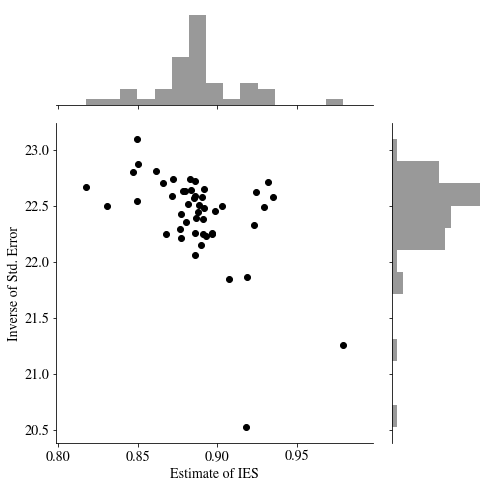

In [36]:
# Plot settings
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Plot
results_df['Estimate of IES'] = results_df['coeff']
results_df['Inverse of Std. Error'] = results_df['inv_stderr']
sns.jointplot(x = 'Estimate of IES', y = 'Inverse of Std. Error', data = results_df, 
              ratio = 3, height = 7, color = 'k')

# Save
plt.savefig('../../figures/regression_state_robustness_check.png', dpi = 300, 
            pad_inches = 0)
plt.show()

In [37]:
results_df['coeff'].describe(percentiles = [0.025, 0.975]).round(decimals = 4)

count    48.0000
mean      0.8873
std       0.0280
min       0.8173
2.5%      0.8333
50%       0.8860
97.5%     0.9343
max       0.9793
Name: coeff, dtype: float64